In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, GlobalMaxPooling2D, Flatten, Concatenate, Conv2D, Input, Flatten, MaxPooling2D, concatenate 

from keras.applications.nasnet import NASNetLarge, NASNetMobile

%matplotlib inline

Using TensorFlow backend.


In [3]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import calculate_auc, auc

W0614 20:29:12.135343 140302327373952 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/utils/comparams.py:1: The name tf.local_variables_initializer is deprecated. Please use tf.compat.v1.local_variables_initializer instead.



### Data Generator

In [4]:
data_dir = './data/macenko/'

In [5]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', 
                                               limit=None, val_limit=None, norm='macenko')
len(x_train), len(x_valid)

(261756, 32728)

In [6]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

## MODEL

In [7]:
input_shape = (96,96,3)

In [8]:
def build_arch_8_net(input_shape=(96,96,3)):
    
    inputs = Input(input_shape)
    nasnet = NASNetMobile(input_tensor=inputs, weights='imagenet', include_top=False)
    x = nasnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

    # Train only the top layer
    for layer in nasnet.layers:
        layer.trainable = False

    model = Model(inputs=nasnet.inputs, outputs=y)

    return model

In [9]:
def build_arch_10_net(input_shape=(96,96,3)):
    
    inputs = Input(input_shape)
    nasnet = NASNetMobile(input_tensor=inputs, weights='imagenet', include_top=False)
    x = nasnet.output
    x = Conv2D(64, (1,1), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

    # Train only the top layer
    for layer in nasnet.layers:
        layer.trainable = False

    model = Model(inputs=nasnet.inputs, outputs=y)

    return model

In [10]:
def build_arch_11_net(input_shape=(96,96,3)):
    
    inputs = Input(input_shape)
    nasnet = NASNetMobile(input_tensor=inputs, weights='imagenet', include_top=False)
    x = nasnet.output
    x = Conv2D(64, (1,1), activation='relu')(x)
    out1 = GlobalAveragePooling2D()(x)
    out2 = GlobalMaxPooling2D()(x)
    out3 = Flatten()(x)
    concat = Concatenate(axis=-1)([out1, out2, out3])
    x = Dense(128, activation='relu')(concat)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

    # Train only the top layer
    for layer in nasnet.layers:
        layer.trainable = False

    model = Model(inputs=nasnet.inputs, outputs=y)

    return model

In [11]:
model = build_arch_10_net(input_shape)

W0614 20:30:15.854148 140302327373952 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 20:30:15.863997 140302327373952 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 20:30:15.865573 140302327373952 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0614 20:30:15.877606 140302327373952 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/t

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 47, 47, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 47, 47, 32)   0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

### Compile

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_auc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
optimizer = Adam(lr=0.001)#, beta_1=0.9, beta_2=0.999)
loss = 'binary_crossentropy'
# categorical_crossentropy
metrics = ['acc', auc]

In [15]:
model.compile(optimizer, loss, metrics)

W0614 20:30:35.958150 140302327373952 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0614 20:30:36.156013 140302327373952 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3378: The name tf.nn.sigmoid_cross_entropy_with_logits is deprecated. Please use tf.nn.sigmoid_cross_entropy_with_logits instead.

W0614 20:30:36.157232 140302327373952 deprecation.py:323] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:179: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0614 20:30:36.170

## Train the model

In [17]:
model_name = 'nasnet_mobile_model_bin_cross_arch_10_lr_0_001'

In [18]:
# Define batch size.
batch_size = 128
n_epoch = 10
# time_limit = 500 # time limit in minute (500 -> 8 hrs and 20 min)

# Parameters for generators
train_params = {
    'dim': (input_shape[0], input_shape[1]),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
    'shuffle': True
}

val_params = {
    'dim': (input_shape[0], input_shape[1]),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
    'shuffle': True
}


# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **val_params)

# Callbacks,
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]#, TimerCallback(1, on_interrupt=saveWeights)]
#roc_callback(training_data=training_generator,validation_data=validation_generator)

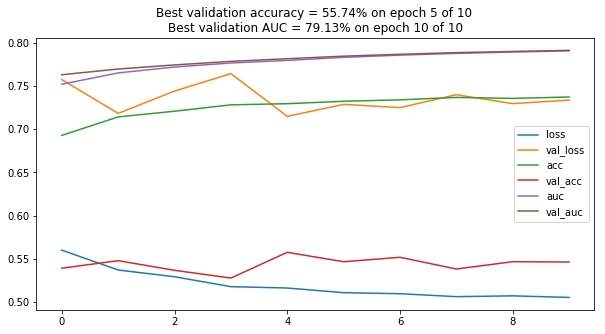

In [19]:
# Training with learning 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)